<b>INPUTS</b> <br>
*  <code>model_names_all</code>: list of model names
*  <code>seas_str</code>:  name of season (use <code>ALL</code> for year-round)
*  <code>thresh_str</code>:  threshold of VRILE strength (<code>05</code> or <code>10</code>)

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [12]:
#model_names = ['ecmwf','metreofr','ukmo','ncep']
ALL_REGIONS = False 
model_names = ['ecmwf','ukmo','metreofr','ncep']
seas_str = 'JJA'
seas_sel = [6,7,8]
vrile_thresh = '05'
clim_freq = 'DAILY'
TO_PLOT = 'SIE RMSE'

### Steps
1. Load on RMSE spreadsheets for all days and VRILE days, and combine all models into one spreadsheet 
2. Make postage stamp plot for each region comparing all days to VRILE days
3. Plot select regions for paper


Load spreadsheets

In [13]:
d_SIE_all = pd.DataFrame()
d_SIE_all_VRILE = pd.DataFrame()
fpath_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/'
for i_model in model_names:
    # Load ALL DAYS
    fpath_all = fpath_load+'{model_name}/RMSE_MAE_{model_name}_months{seas_str}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                            seas_str=seas_str,
                                                                                            clim_freq=clim_freq)
    d_SIE = pd.read_csv(fpath_all)
    # Because we spelled "meteofr" wrong
    if i_model == 'metreofr':
        d_SIE['Model Name'] = 'meteofr'
    else:
        d_SIE['Model Name'] = i_model
    d_SIE['Type'] = 'All Days'
    # 
    d_SIE_all = d_SIE_all.append(d_SIE)
    # Load in VRILE days
    d_SIE_VRILE = pd.read_csv(fpath_load+'{model_name}/RMSE_MAE_{model_name}_months{seas_str}_VRILE{thresh}_model_clim_freq_{clim_freq}.csv'.format(model_name=i_model,
                                                                                            seas_str=seas_str,thresh=vrile_thresh,
                                                                                            clim_freq=clim_freq))
    # Because we spelled "meteofr" wrong
    if i_model == 'metreofr':
        d_SIE_VRILE['Model Name'] = 'meteofr'
    else:
        d_SIE_VRILE['Model Name'] = i_model
    d_SIE_VRILE['Type'] = 'VRILE Days'
    d_SIE_all_VRILE = d_SIE_all_VRILE.append(d_SIE_VRILE)

Now, for each region, we'll plot the RMSE of sea ice extent as a function of lead time for each model (colors). We'll compare our predictions of SIE on all days (solid lines) vs VRILE days only (dashed lines).

,region,lead days,SIE RMSE,SIE anom RMSE,SIE MAE,SIE anom MAE,Model Name,Type
0,Atlantic,2,0.448180,0.064550,0.442303,0.053497,ecmwf,VRILE Days
1,Atlantic,5,0.428196,0.062701,0.421852,0.051770,ecmwf,VRILE Days
2,Atlantic,9,0.385633,0.091276,0.377793,0.074221,ecmwf,VRILE Days
3,Atlantic,12,0.354618,0.089861,0.345490,0.073880,ecmwf,VRILE Days
4,Atlantic,16,0.258427,0.108526,0.250175,0.089811,ecmwf,VRILE Days
...,...,...,...,...,...,...,...,...
855,panArctic,39,0.616748,0.539075,0.521373,0.445979,ncep,VRILE Days
856,panArctic,40,0.627903,0.545603,0.538578,0.456194,ncep,VRILE Days
857,panArctic,41,0.638414,0.547774,0.547659,0.459130,ncep,VRILE Days
858,panArctic,42,0.645424,0.550483,0.551175,0.454086,ncep,VRILE Days


In [14]:
#do we want to plot all regions, or just the ones we are interested in for our paper?
regions_all = d_SIE_all['region'].unique().tolist()
regions_drop = ['St John','Hudson Bay','Canadian Islands','Bering','Sea of Okhotsk']
regions_sel = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]['region'].unique().tolist()
if ALL_REGIONS == True:
    regions_list = regions_sel
    ncols = 5
    reg_save_str = 'REG_ALL'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/RMSE_VRILE_days_vs_all_days/'
    ftype = 'png'
else:
    regions_list = ['panArctic','Barents Sea','East Greenland Sea','Central Arctic','Kara-Laptev Sea',
                     'East Siberian-Beaufort-Chukchi Sea']
    ncols = 3
    reg_save_str = 'REG_TRIM'
    fpath_save = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/figures/RMSE_VRILE_days_vs_all_days/'
    ftype='png'
if not os.path.exists(fpath_save):
    os.makedirs(fpath_save)

Now, we sort RMSE/MAE as a function of region, model, type (VRILE days only vs all days), and lead time

In [15]:
d_SIE_all = d_SIE_all[~d_SIE_all['region'].isin(regions_drop)]
d_SIE_all_gb = d_SIE_all.groupby(['region','Model Name','Type','lead days']).mean()
d_SIE_all_gb
d_SIE_all_VRILE_gb = d_SIE_all_VRILE.groupby(['region','Model Name','Type','lead days']).mean()
#d_SIE_all_VRILE_gb['SIE RMSE'].xs(('Atlantic','ecmwf')).values - d_SIE_all_gb['SIE RMSE'].xs(('Atlantic','ecmwf')).values

Load SIE clim benchmark

In [16]:
if TO_PLOT == 'SIE RMSE':
    SIE_clim_benchmark_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/obs_SIE_clim_benchmark.csv'
    SIE_clim_benchmark = pd.read_csv(SIE_clim_benchmark_load)
else:
    SIE_clim_benchmark_load = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/obs_SIE_anom_clim_benchmark.csv'
    SIE_clim_benchmark = pd.read_csv(SIE_clim_benchmark_load)


In [17]:
SIE_clim_benchmark['valid month'] = pd.to_datetime(SIE_clim_benchmark['valid day of year'],format="%m-%d")
SIE_clim_benchmark_seas = SIE_clim_benchmark[SIE_clim_benchmark['valid month'].dt.month.isin(seas_sel)]
SIE_clim_benchmark_plot = SIE_clim_benchmark_seas.groupby(['region'])['r2','rmse'].mean()

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


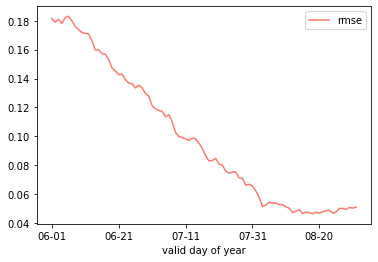

In [18]:
poo = SIE_clim_benchmark_seas.where(SIE_clim_benchmark_seas['region']=='Barents Sea').dropna(how='all')
poo.plot(x='valid day of year',y='rmse')

Plot regions of interest

In [19]:

if TO_PLOT == 'SIE RMSE':
    title_str = 'Sea Ice Extent'
    save_str = 'SIE'
else:
    title_str = 'Anomalous Sea Ice Extent'
    save_str = 'SIE_anom'

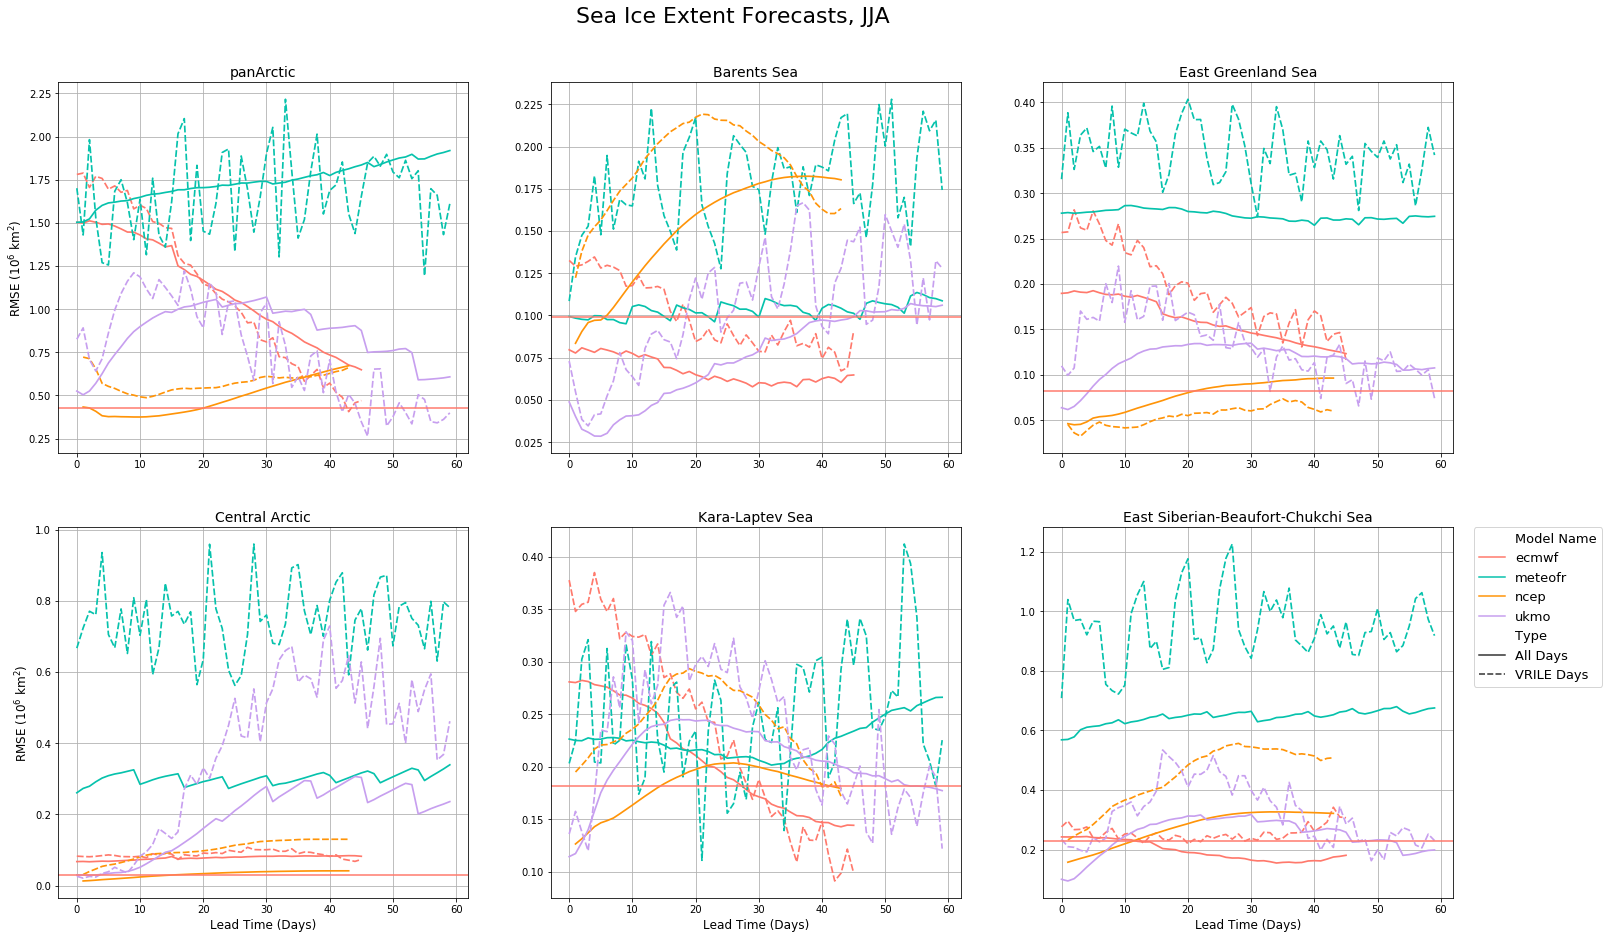

In [20]:
nrows = np.int(len(regions_list)/ncols)
no_regions = len(regions_list)
fig3,ax3 = plt.subplots(nrows,ncols,figsize=(25,15))
for i in range(0,no_regions):
    # Palette
    test_pal = ['salmon','turquoise','tangerine','lavender']
    sns.set_palette(sns.xkcd_palette(test_pal),4)
    ax_sel = ax3.flat[i]
    #print(ax_sel)
    reg_sel = regions_list[i]
    #print(reg_sel)
    plot_ij = d_SIE_all_gb.xs((reg_sel)).reset_index().append(d_SIE_all_VRILE_gb.xs((reg_sel)).reset_index())
    sns.lineplot(data=plot_ij,x='lead days',y=TO_PLOT,hue='Model Name',
                 style='Type',ax=ax_sel,linewidth=1.7,legend=False if i < no_regions - 1 else 'full')
    ax_sel.axhline(y=SIE_clim_benchmark_plot.loc[reg_sel]['rmse'])
    ##
    ax_sel.grid()
    
    if i >= ncols*(nrows-1):
        ax_sel.set_xlabel('Lead Time (Days)',fontsize=12)
    else:
        ax_sel.set_xlabel(None)
    if np.mod(i,ncols)==0:
        ax_sel.set_ylabel('RMSE (10$^6$ km$^2$)',fontsize=12)
    else:
        ax_sel.set_ylabel(None)
    if i == no_regions-1:
        ax_sel.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0,fontsize=13)
                      
    ax_sel.set_title('{region}'.format(region=reg_sel),fontsize=14)
        
fig3.suptitle('{title_str} Forecasts, {seas_str}'.format(title_str=title_str,seas_str=seas_str),fontsize=22,y=0.95)        
fname_save3 = fpath_save+'{save_str}_forecast_RMSE_{seas_str}_vs_VRILE_{reg_save_str}_VRILEthresh{thresh}.{ftype}'.format(save_str=save_str,
                                                                                                                       reg_save_str=reg_save_str,
                                                                                                                          seas_str=seas_str,
                                                                                                                thresh=vrile_thresh,
                                                                                                               ftype=ftype)
fig3.savefig(fname_save3,format=ftype,dpi=400,bbox_inches='tight')

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


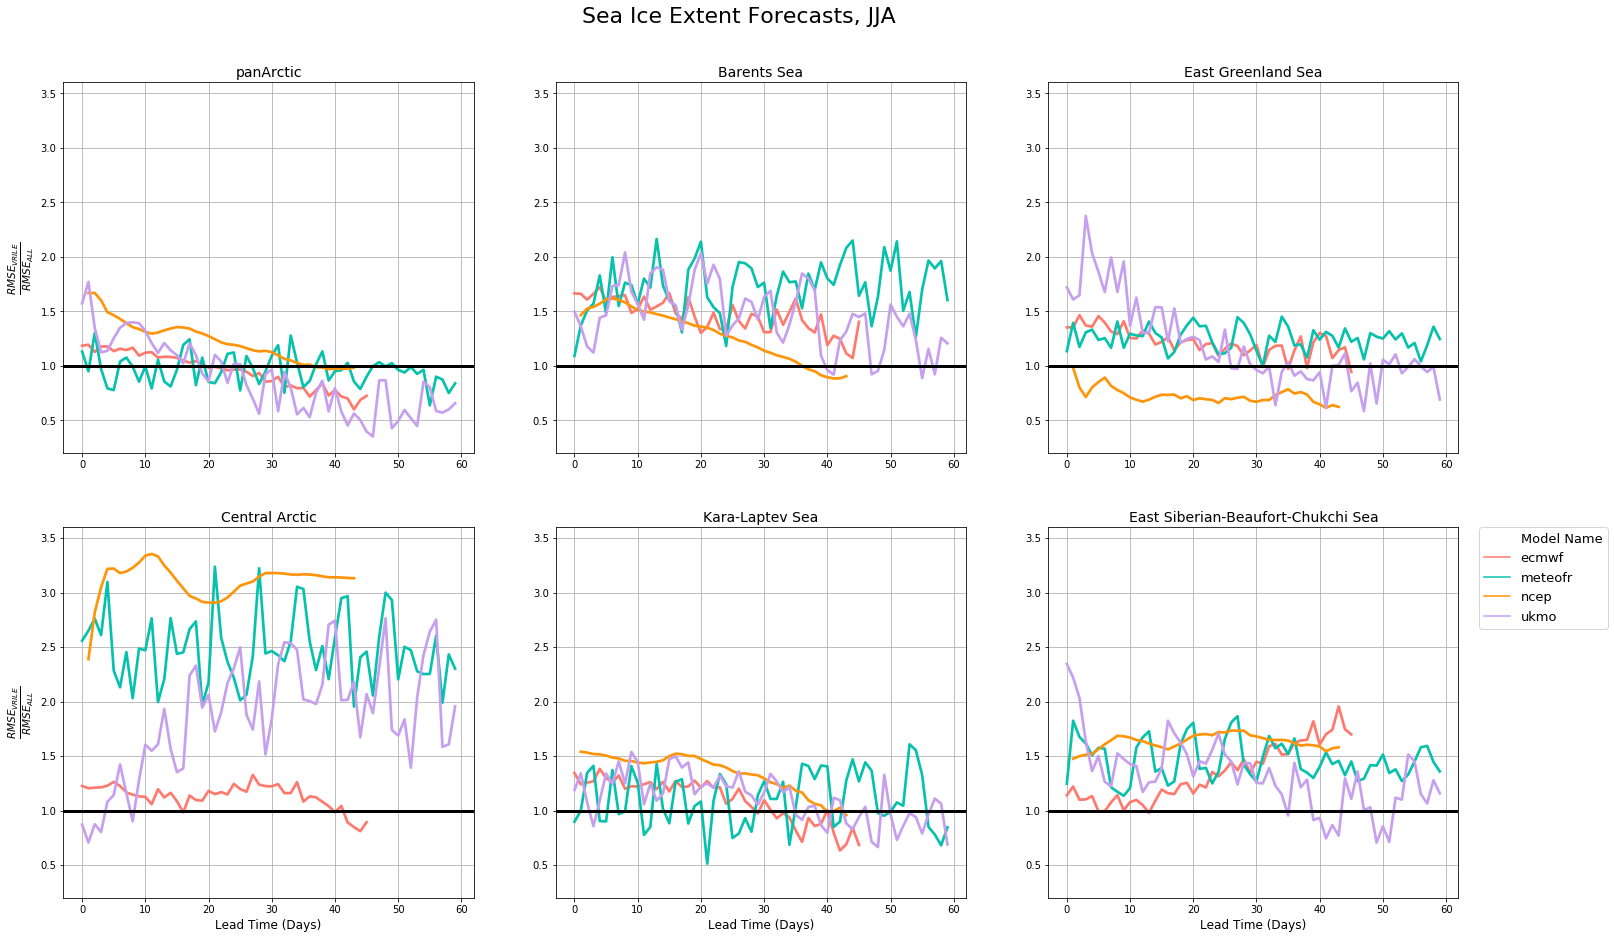

In [21]:
ratios = d_SIE_all_VRILE.groupby(['region',
         'Model Name','lead days'])['SIE RMSE','SIE anom RMSE'].mean().divide(d_SIE_all.groupby(['region',
         'Model Name','lead days'])['SIE RMSE','SIE anom RMSE'].mean())
y_max = ratios.max()[TO_PLOT]
y_min = ratios.min()[TO_PLOT]
#sns.lineplot(data=plt2,x='lead days',y=TO_PLOT,hue='Model Name',style='Type')
fig4,ax4 = plt.subplots(nrows,ncols,figsize=(25,15))
for i in range(0,no_regions):
    # Palette
    test_pal = ['salmon','turquoise','tangerine','lavender']
    sns.set_palette(sns.xkcd_palette(test_pal),4)
    ax_sel = ax4.flat[i]
    #print(ax_sel)
    reg_sel = regions_list[i]
    #print(reg_sel)
    sns.lineplot(data=ratios.xs((reg_sel)).reset_index(),x='lead days',y=TO_PLOT,hue='Model Name',
                ax=ax_sel,linewidth=2.7,legend=False if i < no_regions - 1 else 'full')
    ax_sel.axhline(y=1,xmin=0,xmax=46,color='k',linewidth=3)
    ##
    ax_sel.grid()
    if i >= ncols*(nrows-1):
        ax_sel.set_xlabel('Lead Time (Days)',fontsize=12)
    else:
        ax_sel.set_xlabel(None)
    if np.mod(i,ncols)==0:
        ax_sel.set_ylabel(r'$\frac{RMSE_{VRILE}}{RMSE_{ALL}}$',fontsize=15)
    else:
        ax_sel.set_ylabel(None)
    if i == no_regions-1:
        ax_sel.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0,fontsize=13)
                      
    ax_sel.set_title('{region}'.format(region=reg_sel),fontsize=14)

    ax_sel.set_ylim([np.max(np.round(y_min-0.2,1),0),np.round(y_max+0.2,1)])
        
fig4.suptitle('{title_str} Forecasts, {seas_str}'.format(title_str=title_str,seas_str=seas_str),fontsize=22,y=0.95)        
fname_save4 = fpath_save+'{save_str}_forecast_RMSE_VRILE_vs_ALL_RATIO_{seas_str}_{reg_save_str}_VRILEthresh{thresh}.{ftype}'.format(save_str=save_str,
                                                                                                                       reg_save_str=reg_save_str,
                                                                                                                          seas_str=seas_str,
                                                                                                                thresh=vrile_thresh,
                                                                                                               ftype=ftype)
fig4.savefig(fname_save4,format=ftype,dpi=400,bbox_inches='tight')